# Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/proplot/utils.py:105: ProPlotWarning: Rebuilding font cache.


3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 244 GB / percent used: 3.1 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(-90,90)
lonlim=(0,360)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Load surface pressure for masking NCEP

In [28]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ncep-Interim
ps_ncep = xr.open_dataset(
    "/bdd/ncep2/mon-mean/surf/pres.sfc.mon.mean.nc"
).pres.sel(time=period).load()

In [32]:
regridder = xe.Regridder(ps_ncep, ps, 'bilinear', periodic=True, reuse_weights=True)
ps_ncep_regrid = regridder(ps_ncep)

ps = ps.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ps_ncep_regrid = ps_ncep_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

# Get the minimum pressure (finally not used)
ps_min = ps.min('time')
ps_ncep_regrid_min = ps_ncep_regrid.min('time')

Reuse existing file: bilinear_73x144_143x144_peri.nc


# Load Air Temperature

In [33]:
var ='ta'

ta = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period)[var].load()-273.15

ta_ncep = xr.open_mfdataset(
    '/bdd/ncep2/mon-mean/press/air.mon.mean.nc',
    combine='by_coords', parallel=True
).air.sel(time=period).load()-273.15

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/xarray/conventions.py:487: SerializationWarning: variable 'air' has multiple fill values {-32767, 32766}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


## Regrid horizontal

In [34]:
# Regrid horizontal
ta_ncep_regrid = regridder(ta_ncep)

## Select zone

In [35]:
ta = ta.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ta_ncep_regrid = ta_ncep_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Mask vertical values > ps

In [36]:
ta_ncep_regrid_masked = ta_ncep_regrid.where(ta_ncep_regrid.level <= ps_ncep_regrid/100)

## Regrid vertical

In [40]:
ta_ncep_regrid_masked_v = ta_ncep_regrid_masked.interp(level=(ta.plev.values/100), method='linear')

## Compute climatologie

In [41]:
ta_clim = ta.mean('time', skipna=False).load()
ta_ncep_regrid_masked_clim = ta_ncep_regrid_masked.mean('time', skipna=False).load()
ta_ncep_regrid_masked_v_clim = ta_ncep_regrid_masked_v.mean('time', skipna=False).load()

ta_bias = ta_clim-ta_ncep_regrid_masked_v_clim.values

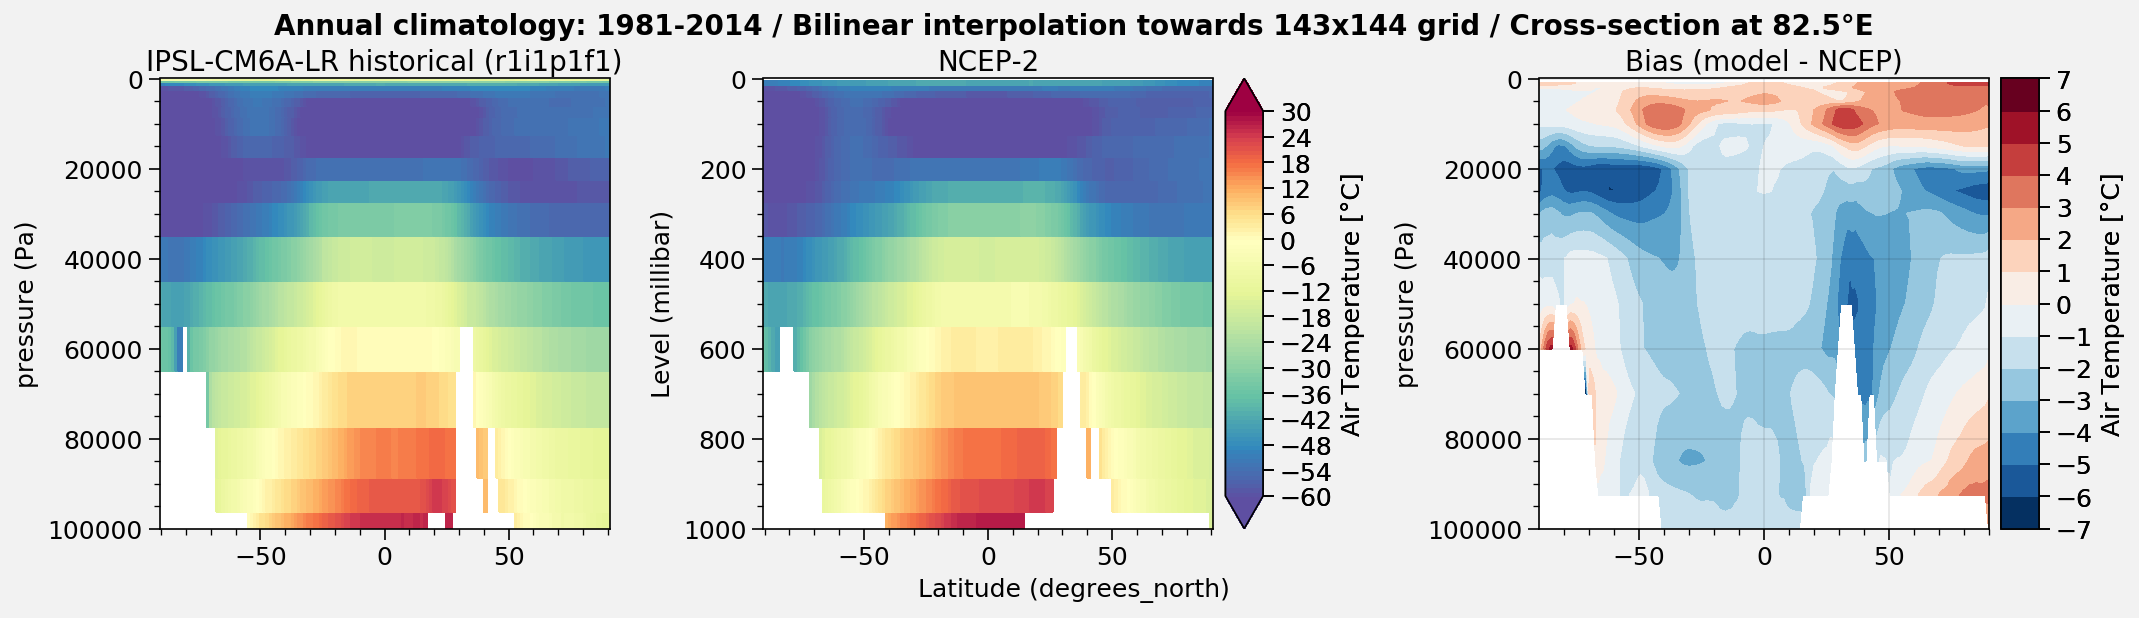

In [43]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_ncep_regrid_masked_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='NCEP-2')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lon=82.5), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - NCEP)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global_ncep2.png')
# f.save('img/ta/slice_lon_82_5_ta_pcolormesh_global_ncep2.pdf')

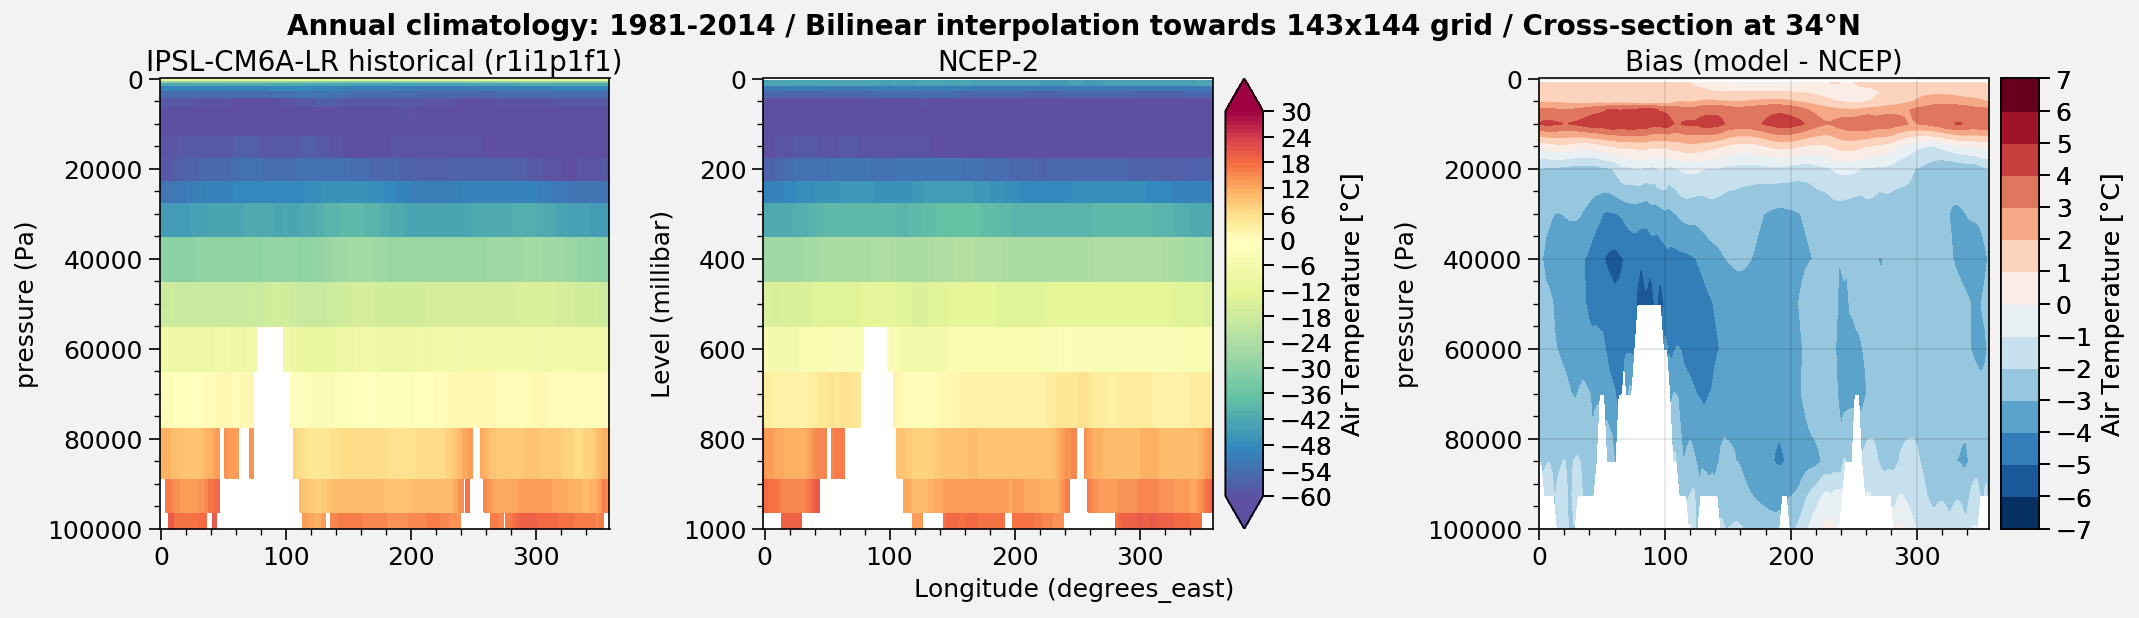

In [44]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ta_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ta_ncep_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='NCEP-2')
axs[1].colorbar(m1, label='Air Temperature [°C]')

# Bias
m2 = axs[2].contourf(ta_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1))
axs[2].format(ylim=(100000,0), title='Bias (model - NCEP)')
axs[2].colorbar(m2, label='Air Temperature [°C]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 34°N"
)

# f.save('img/ta/slice_lat_34_ta_pcolormesh_global_ncep2.png')
# f.save('img/ta/slice_lat_34_ta_pcolormesh_global_ncep2.pdf')